In [1]:
import pandas as pd
import sys

infile='/Users/irffanalahi/Research/Research_update/SoftRD/hashtable_stats/CD8TIL_CD8PBL_meltumor/deltaCD8tilCD8pbl_thresholdpos_allthresholdcombinations_stat.txt'  #'/Users/irffanalahi/Research/Research_update/SoftRD/hashtable_stats/tieredApproach/BL22_groupv2/em4_cm4/cm4_thresholdpos_allthresholdcombinations_Shoonhsin_avg_and_linecount.txt'


owngroup='mel'
celltype='CD8TIL'

minimumTOTALcpg=1000


owngroupcelltype=owngroup+celltype


indf=pd.read_csv(infile,sep='\t')
indf.head()

,Filename,Average Value,Line Count
0,CD8TIL_CD8patientPBLCD8TIL_-0.6_int_CD8TIL_mel...,0.5,641
1,CD8TIL_CD8patientPBLCD8TIL_-0.6_int_CD8TIL_mel...,0.4,1577
2,CD8TIL_CD8patientPBLCD8TIL_-0.2_int_CD8TIL_mel...,0.5,1345
3,CD8TIL_CD8patientPBLCD8TIL_-0.2_int_CD8TIL_mel...,0.4,9564
4,CD8TIL_CD8patientPBLCD8TIL_-0.4_int_CD8TIL_mel...,0.4,5735


In [2]:
indf['other_group']=-999
indf['other_group_sum']=-999  ##############
indf['own_group']=-999

indf.head()

,Filename,Average Value,Line Count,other_group,other_group_sum,own_group
0,CD8TIL_CD8patientPBLCD8TIL_-0.6_int_CD8TIL_mel...,0.5,641,-999,-999,-999
1,CD8TIL_CD8patientPBLCD8TIL_-0.6_int_CD8TIL_mel...,0.4,1577,-999,-999,-999
2,CD8TIL_CD8patientPBLCD8TIL_-0.2_int_CD8TIL_mel...,0.5,1345,-999,-999,-999
3,CD8TIL_CD8patientPBLCD8TIL_-0.2_int_CD8TIL_mel...,0.4,9564,-999,-999,-999
4,CD8TIL_CD8patientPBLCD8TIL_-0.4_int_CD8TIL_mel...,0.4,5735,-999,-999,-999


In [3]:
def calculateOtherVSowngroup(fname):
    split_lst = fname.split("_")
    total = 0
    n = 0
    
    nums = [str(i) for i in list(range(0, 10))]
    
    prev='garbage'
    
    owngroupdelta=-999
    
    for split in split_lst:
        
        if "-" in split and split[-1] in nums: # confirm that the substring is a negative number
            
            if owngroupcelltype in prev:
                
                owngroupdelta=abs(float(split))
            
            else:
            
                n += 1
                total += float(split)
        else:
            prev=split
            
            
   
    avgs=abs(total / n)
    
    
    return avgs,owngroupdelta,abs(total)

In [4]:
for index, row in indf.iterrows():
    r1,r2,r3=calculateOtherVSowngroup(row['Filename'])
    
    
    indf.iloc[index,indf.columns.get_loc('other_group')]=r1
    
    indf.iloc[index,indf.columns.get_loc('own_group')]=r2
    
    indf.iloc[index,indf.columns.get_loc('other_group_sum')]=r3
    
    

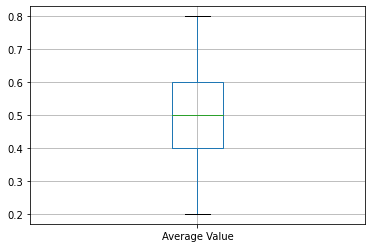

In [5]:
indf.boxplot(column=['Average Value'])

In [22]:
percentile75=indf['Average Value'].quantile(0.75)
percentile50=indf['Average Value'].quantile(0.5)
print(percentile75)
print(percentile50)

0.6000000000000001
0.5


In [7]:
outdfstep0=indf[indf['Average Value']>=percentile75]
outdfstep1=outdfstep0[outdfstep0['Line Count']>minimumTOTALcpg]
if outdfstep1.shape[0]==0:
    outdfstep0=indf[indf['Average Value']>=percentile50]
    outdfstep1=outdfstep0[outdfstep0['Line Count']>minimumTOTALcpg]
    if outdfstep0.shape[0]==0:
        print("Need to see. Not getting 1000 CpGs")
        sys.exit(1)

In [8]:

outdfstep1.head()

,Filename,Average Value,Line Count,other_group,other_group_sum,own_group
2,CD8TIL_CD8patientPBLCD8TIL_-0.2_int_CD8TIL_mel...,0.5,1345,0.2,0.2,0.8
13,CD8TIL_CD8patientPBLCD8TIL_-0.4_int_CD8TIL_mel...,0.5,2139,0.4,0.4,0.6


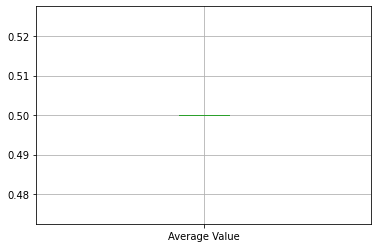

In [9]:
outdfstep1.boxplot(column=['Average Value'])

In [10]:
outdfstep1.shape

(2, 6)

In [11]:
outdfstep1[outdfstep1['Filename']=='g1_cm4_g2_Myloidcm4_-0.8_int_g1_cm4_g2_Bcellcm4_-0.6_int_g1_cm4_g2_PMNlikecm4_-0.8_int_g1_cm4_g2_Tcellcm4_-0.4']

,Filename,Average Value,Line Count,other_group,other_group_sum,own_group


In [12]:
outdfstep1[(outdfstep1['own_group']>=0.4) & (outdfstep1['other_group']>0.6)]

,Filename,Average Value,Line Count,other_group,other_group_sum,own_group


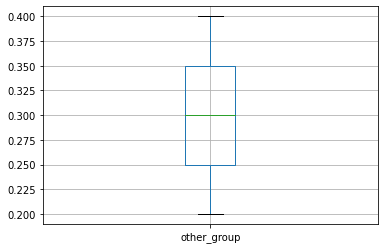

In [13]:
outdfstep1.boxplot(column=['other_group'])

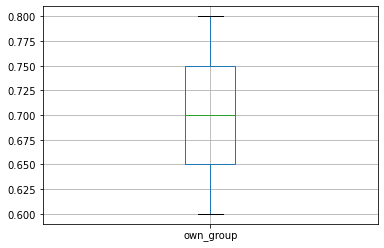

In [15]:
outdfstep1.boxplot(column=['own_group'])

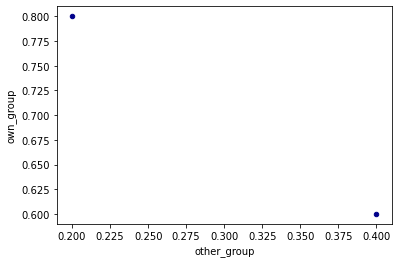

In [16]:
outdfstep1.plot.scatter(x='other_group',y='own_group',c='DarkBlue')

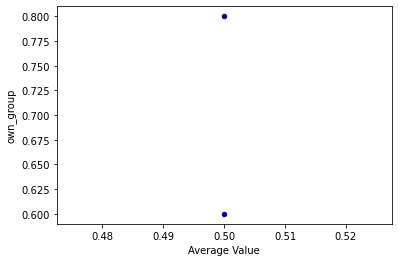

In [17]:
outdfstep1.plot.scatter(x='Average Value',y='own_group',c='DarkBlue')

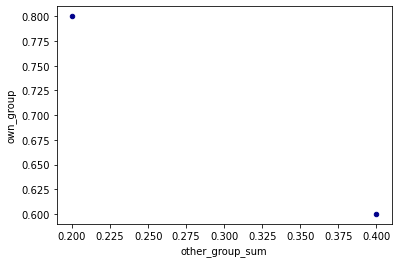

In [18]:
outdfstep1.plot.scatter(x='other_group_sum',y='own_group',c='DarkBlue')

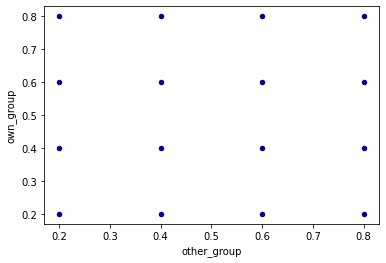

In [19]:
indf.plot.scatter(x='other_group',y='own_group',c='DarkBlue')

In [20]:
#outdfstep1.to_csv(infile+"_st1.txt",sep='\t',index=False)